# Deep Learning Final Project

**Authors:** Aryaman Shodhan ashodha1,
Trisha Karani tkarani1,
Shreya Wadhwa swadhwa5,
Aidan Aug aaug1

**Description:**
This Colab Notebook investigates various segmentation models in segmenting the CholecSeg8k semantic segmentation dataset based on Cholec80. The dataset has the following specifications:
1. A subset of Cholec80, where videos captured the procedure at 25 fps and annotated tools presence and operation phases
2. 13 different object (classes) including black background, abdominal wall, liver, gastrointestinal tract, fat, grasper, connective tissue, blood, cystic duct, L hook electrocautery (Instrument), gallbladder, hepatic vein, and liver ligament (see Data Preprocessing for visualization)
3. 3 masks --> 1 color mask, one mask used by annotation tool, and one watershed mask
4. Images are in RGB
5. Directories are such that each contains 80 consecutive frames of the video with a resolution of 854x480 and the annotated semantic segmentation masks


The link to the official dataset can be found here: https://www.kaggle.com/datasets/newslab/cholecseg8k

# Setup: 

Mounting Drive, importing libraries, and determining device

In [ ]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
## Standard Library
import os
import json
import re
import random

## External Libraries
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
from datetime import datetime
from pytz import timezone
tz = timezone('US/Eastern')

In [ ]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu = True if torch.cuda.is_available() else False

In [ ]:
import random
random.seed(3407)
torch.manual_seed(3407)
np.random.seed(3407)

# Data Preprocessing

NOTE: MAKE SURE TO UPDATE DATA_DIR FOR THE PATH TO THE CholecSeg8k DATA!!!

The below code implements the following dataloading and pre-processing steps:
1. Loads in the data from specified repository
2. Shuffles the data
3. Splits data into an 60:10:10 train-val-test split
4. Generates an ImageDataset class based on this data for feeding into a dataloader
5. Resizes images into 192 x 320 pixel images
6. Visualizes data

In [ ]:
### ENTER BASE DATA DIRECTORY HERE TO PROJECT PATH:
# data_dir = "/content/gdrive/MyDrive/Deep_Learning/" #Aryaman
# data_dir = "/content/gdrive/MyDrive/Notes/Spring 2023/Deep Learning/Deep_Learning/" #Shreya
# data_dir = "/content/gdrive/MyDrive/MLDL/Final_Project/Deep_Learning/" # Aidan
data_dir = "/content/gdrive/MyDrive/Deep_Learning/"  # Trisha

mask_json = f"{data_dir}archive/mapping.json"

# Fetch all of the data paths
data = []
for root, _, files in os.walk(data_dir + "archive"):
  files = sorted(filter(lambda x: re.search("(endo.png$)|(watershed_mask.png$)", x) is not None, files))
  for idx in range(len(files)):
    if (idx % 2 == 0):
      data_point = [os.path.join(root, files[idx])]
    else:
      data_point += [os.path.join(root, files[idx])]
      data.append(data_point)

random.shuffle(data)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data, mask_json, transforms=None):
    self.data = data
    self.mask_json = mask_json
    self.transforms = transforms

    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    return img, mask

In [ ]:
## Divide the data
train_range_end = int(0.8 * len(data))
val_range_end = int(0.9 * len(data))
test_range_end = int(1.0 * len(data))

train_datapoints = data[0:train_range_end]
val_datapoints = data[train_range_end:val_range_end]
test_datapoints = data[val_range_end:test_range_end]

In [ ]:
# NOTE: Training with the entire dataset was too computationally expensive. 
# We have further divded the data into smaller datasets using the following split:
num_train = 600
num_val = 100
num_test = 100

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None), #Ratios must be compatible with DeepLabv3
])

############ Generate DataLoaders ###########

train_dataset = ImageDataset(data=train_datapoints, mask_json=mask_json, transforms=img_transforms)
val_dataset = ImageDataset(data=val_datapoints, mask_json=mask_json, transforms=img_transforms)
test_dataset = ImageDataset(data=test_datapoints, mask_json=mask_json, transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(f"Batches of Training Dataloader: {len(train_dataloader)}")
print(f"Batches of Validation Dataloader: {len(validation_dataloader)}")
print(f"Batches of Testing Dataloader: {len(test_dataloader)}")


Batches of Training Dataloader: 20
Batches of Validation Dataloader: 4
Batches of Testing Dataloader: 100


### Visualize Data

In [ ]:
def visualize(dataloader, n_batches=1, n_samples=1):
    for _ in range(n_batches):
        img, mask = next(iter(dataloader))
        
        img = img.numpy().transpose(0, 2, 3, 1)
        mask = mask.numpy().transpose(0, 2, 3, 1)

        for i in range(n_samples): 
            fig, ax = plt.subplots(1, 2, figsize=(9, 3))
            ax[0].imshow(img[i])
            ax[0].set_title("Input Image")    

            ax[1].imshow(np.argmax(mask[i], axis=-1), cmap="gray")
            ax[1].set_title("Ground Truth")

        plt.show()

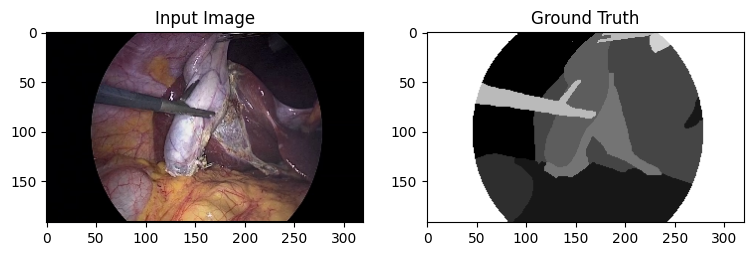

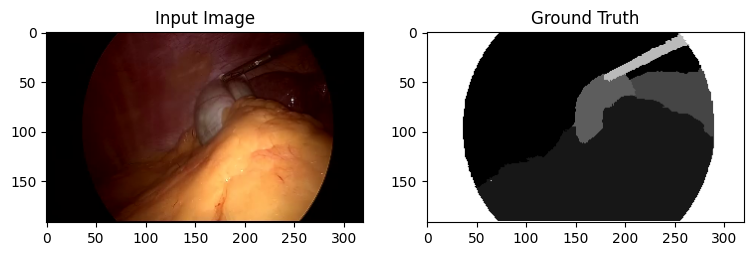

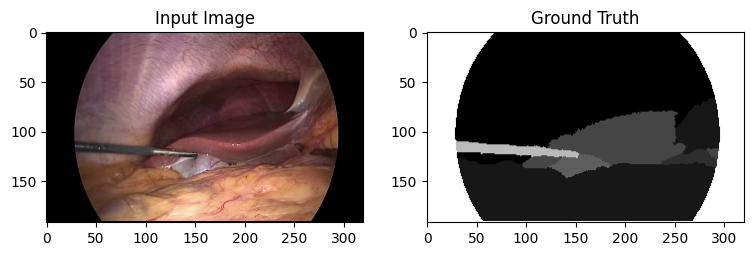

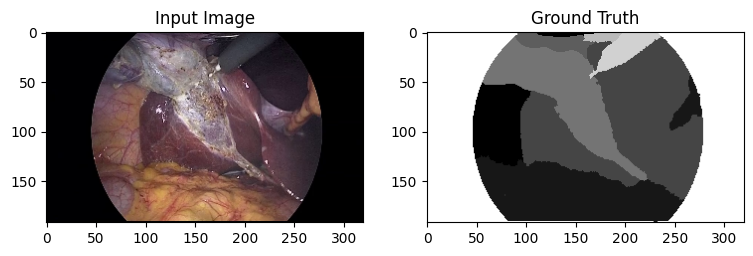

In [ ]:
visualize(train_dataloader, n_samples=4)

# Loss Functions

TODO: INCLUDE DESCRIPTION OF RATIONALE BEHIND DICELOSS AND IOU

Dice Loss

Remember to include references about where we got the equation from!

https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf

In [ ]:
# IOU Loss = 1 - (|A intersect B| / |A union B|)
class IOULoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(IOULoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks, n_classes):
    batch_size = target_masks.shape[0]
    iou_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      iou_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        iou_classes[cl] = intersection / (predicted_mask[cl].sum() + target_mask[cl].sum() - intersection)
      iou_scores[batch] = iou_classes.mean()
    return 1.0 - iou_scores.mean()

In [ ]:
# DICE Loss = 1 - (2 * |A intersect B| / (|A| + |B|))
class DICELoss(nn.Module):
  """
  predicted_mask: One Hot Array
  target_mask: One Hot Array
  """
  def __init__(self):
    super(DICELoss, self).__init__()
  
  def forward(self, predicted_masks, target_masks):
    n_classes = predicted_masks.shape[1]
    batch_size = target_masks.shape[0]
    dice_scores = torch.zeros(batch_size)
    for batch in range(batch_size):
      predicted_mask = predicted_masks[batch]
      target_mask = target_masks[batch]
      dice_classes = torch.zeros(n_classes)
      for cl in range(n_classes):
        intersection = (predicted_mask[cl] * target_mask[cl]).sum()
        dice_classes[cl] = 2 * intersection / (predicted_mask[cl].sum() + target_mask[cl].sum())
      dice_scores[batch] = dice_classes.mean()
    return 1.0 - dice_scores.mean()

In [ ]:
## Loss Functions Testing

# Batch has 1 item with 3 classes
predicted = torch.Tensor([
    # Class 1
    [[[0.2, 0.1, 0.05],
    [0.1, 0.3, 0.4],
    [0.6, 0.75, 0.25]],

    # Class 2
    [[0.25, 0.1, 0.9],
    [0.45, 0.2, 0.3],
    [0.2, 0.15, 0.05]],

    # Class 3
    [[0.55, 0.8, 0.05],
    [0.45, 0.5, 0.3],
    [0.2, 0.1, 0.7]]]
])

# Batch has 1 item with 3 classes
target = torch.Tensor([
    # Class 1
    [[[0, 0, 0],
    [0, 0, 1],
    [1, 0, 0]],

    # Class 2
    [[1, 0, 1],
    [0, 1, 0],
    [0, 1, 0]],

    # Class 3
    [[0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]]]
])

# IOU Score for Class 1: 1.0 / (2.0 + 2.75 - 1.0) = 0.2667
# IOU Score for Class 2: 1.5 / (4.0 + 2.6 - 1.5) = 0.2941
# IOU Score for Class 3: 1.95 / (3.0 + 3.65 - 1.95) = 0.4149
# Mean IOU Score: 0.3252
# Loss = 1 - 0.3252 = 0.6748
iou = IOULoss()
iou_loss = iou.forward(predicted, target, n_classes=3).item()
assert(iou_loss == 0.6747740507125854)

# DICE Score for Class 1: 2 * 1.0 / (2.0 + 2.75) = 0.4211
# DICE Score for Class 2: 2 * 1.5 / (4.0 + 2.6) = 0.4545
# DICE Score for Class 3: 2 * 1.95 / (3.0 + 3.65) = 0.5865
# Mean DICE Score: 0.4874
# Loss = 1 - 0.4874 = 0.5126
dice = DICELoss()
# dice_loss = dice.forward(predicted, target, n_classes=3).item()
dice_loss = dice.forward(predicted, target).item()

assert(dice_loss == 0.5126452445983887)

In [ ]:
def dice_score_image(prediction, target, n_classes):
    dice_classes = np.zeros(n_classes)

    for cl in range(n_classes):
      target_cl = target[:, cl, :, :]
      prediction_cl = prediction[:, cl, :, :]

      TP = (prediction_cl * target_cl).sum().item()
      FP = ((1 - target_cl) * prediction_cl).sum().item()
      FN = (target_cl * (1 - prediction_cl)).sum().item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      if target_cl.sum() == 0 and FP == 0:
          dice_classes[cl] = 1.0
      elif target_cl.sum() == 0 and FP > 0:
          dice_classes[cl] = 0.0
      else:
        dice_classes[cl] = 2 * TP / (2 * TP + FP + FN)
    return dice_classes.mean()


def dice_score_dataset(model, dataloader, use_gpu=False, is_deeplab_or_fcn=False):
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)

    model.eval()
    idx = 0
    for data in dataloader:

        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()

        out = model(img)
        if is_deeplab_or_fcn:
          out = out['out']
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = nn.functional.one_hot(prediction, n_classes)
        prediction = prediction.permute(0, 3, 1, 2)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1

    m_dice = scores.mean()
    return m_dice

# Training and Validation

In [ ]:
def test_eval(test_dataloader, model, loss, is_deeplab_or_fcn=False, verbose = 1):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          if i <= 5:
            fig, ax = plt.subplots(1, 3)
            img = outputs[0]
            img = np.argmax(img.cpu().numpy(), axis=0)
            ax[0].imshow(img, cmap="gray")
            ax[0].set_title("Predicted")    

            ax[1].imshow(np.argmax(labels[0].cpu().numpy(), axis=0), cmap="gray")
            ax[1].set_title("Labels")

            input = images[0].permute(1, 2, 0).cpu().numpy()
            ax[2].imshow(input)
            ax[2].set_title("Input")

            plt.show()
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Test loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def val_eval(val_dataloader, model, loss, is_deeplab_or_fcn=False, verbose = 0):
    total = 0
    loss_sum = 0
    i = 0
    with torch.no_grad():
      for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          if is_deeplab_or_fcn:
            outputs = outputs['out'] # Only for DeepLabV3
          total += labels.size(0)
          loss_sum += loss(outputs, labels)
          i += 1

    if verbose:
        print('Val loss: %f' % (loss_sum.cpu().data.numpy().item() / total))

    return loss_sum.cpu().data.numpy().item() / total

In [ ]:
def train(model, train_data_loader, validation_dataloader, optimizer, loss, num_epochs, is_deeplab_or_fcn=False):

  loss_fail = 0
  patience = 5
  best_model = model
  best_val_loss = float('inf')
  n_classes = 13
  print("Start Training...")
  print("{:<10} {:<20} {:<20} {:<20} {:<15} {:<15}".format('epoch', 'train loss','val loss', 'es_counter(/5)', 'min_val_loss', 'time(s)'))
  time_start = time.time() #timekeeping
  for epoch in range(num_epochs):
      ########################### Training #####################################
      time_epoch_start = time.time() #timekeeping
      loss_sum = 0
      correct = 0
      total = 0
      for i, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        if is_deeplab_or_fcn:
          outputs = outputs['out'] #only for DeepLabV3
        loss_val = loss(outputs, y)
        loss_val.backward()
        optimizer.step()

        # train eval
        loss_sum += loss_val.item()
        total += y.size(0)

      train_loss = loss_sum / total
      ########################### Validation #####################################
      val_loss = val_eval(validation_dataloader, model, loss, is_deeplab_or_fcn)

      # Early Stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        loss_fail = 0
      else:
        loss_fail += 1
      
      if loss_fail == patience:
          print("Stopping Early..")
          print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n", "Train Loss:",train_loss, "Validation Loss:",val_loss)
          break

      # Timekeeping
      time_epoch_end = time.time()
      total_time = time_epoch_end - time_start

      # Print statements + data keeping for graph
      if epoch % 2 == 0:
          print("{:<10} {:<20f} {:<20f} {:<20d} {:<15f} {:<15f}".format(
            epoch, train_loss, val_loss, loss_fail, round(best_val_loss,10), total_time))
      if epoch == 0:
          L = train_loss
          A = val_loss
      else:
          L = np.append(L,train_loss)
          A = np.append(A,val_loss)

  ## Plot Training Loss and Validation Loss
  plt.plot(L,'-', label='Training Loss')
  plt.plot(A,'-', label='Validation Loss')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='best')
  plt.show()

  return best_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EXPERIMENT 1 Comparing different segmentation models

This notebook explores the performance of a FCN model for image segmentation and in Experiment 1, we will be retraining the entire model.

## FCN

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.074246             0.038608             0                    0.038608        113.349447     
2          0.016399             0.016417             0                    0.016417        330.864299     
4          0.008385             0.008471             0                    0.008471        551.719820     
6          0.005387             0.007264             0                    0.007264        774.559971     
8          0.004364             0.005681             0                    0.005681        993.743027     
10         0.004090             0.007520             1                    0.005449        1210.337796    
12         0.003721             0.004942             0                    0.004942        1426.022233    
14         0.003072             0.004806             1                    0.004740        1643.910572    
16         0.003233         

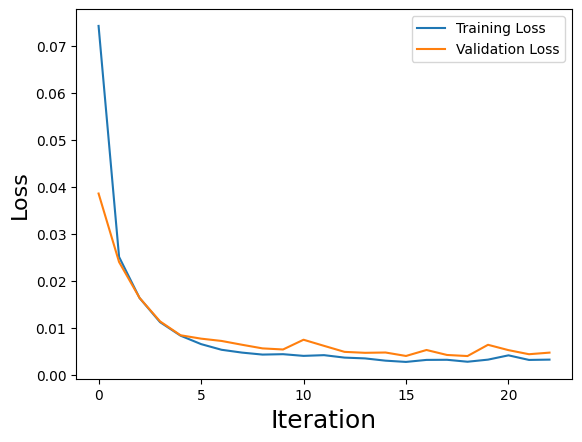

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.fcn_resnet50()

model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(256, 13, kernel_size=1, stride=1)
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_trained = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_trained, test_dataloader, use_gpu, True)

0.9441112640815341

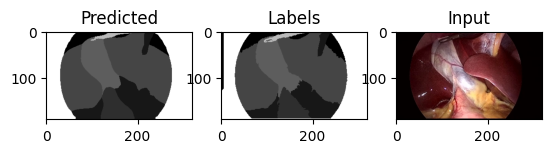

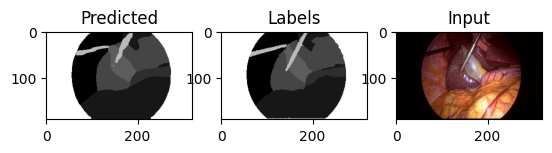

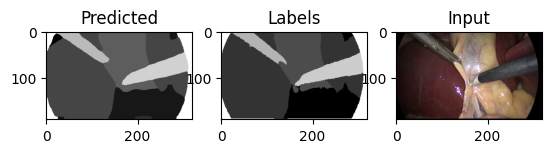

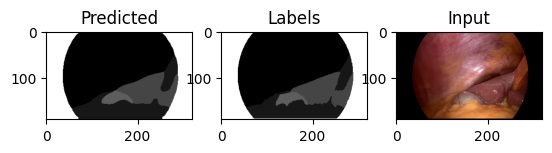

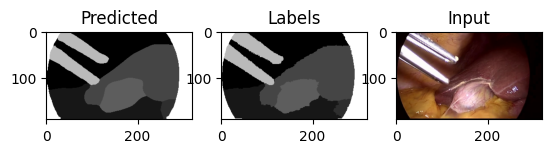

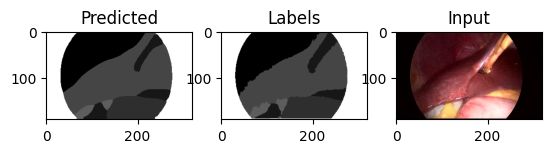

Test loss: 0.092703


0.09270341074117465

In [ ]:
test_eval(test_dataloader, fcn_trained, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_trained, data_dir + f"saved_models/models/fcn_trained_{cur_time}.pt")

# EXPERIMENT 2 TRANSFER LEARNING USING A SPECIFIC MODEL

This notebook explores the performance of a FCN model for image segmentation and in Experiment 2, we will be only be retraining the last layer of the model.

## FCN

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 89.4MB/s]


Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.055849             0.043937             0                    0.043937        94.809386      
2          0.027662             0.033170             0                    0.033170        281.792285     
4          0.022150             0.026714             0                    0.026714        476.053099     
6          0.018348             0.022095             0                    0.022095        666.270574     
8          0.016220             0.018674             0                    0.018674        855.844985     
10         0.015840             0.017301             1                    0.016978        1044.371251    
12         0.014551             0.015655             0                    0.015655        1232.787841    
14         0.012301             0.014987             1                    0.014981        1417.382525    
16         0.012349         

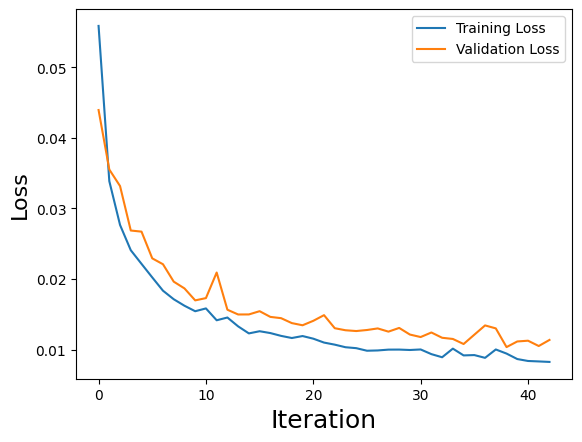

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_transfer = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_transfer, test_dataloader, use_gpu, True)

0.8674703309998222

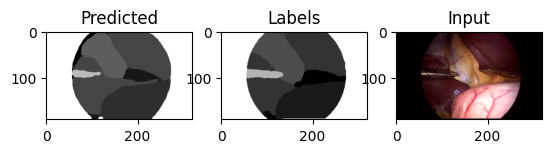

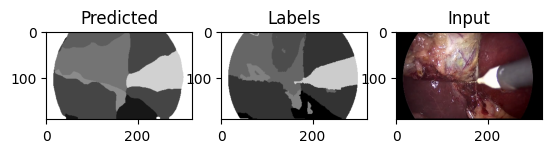

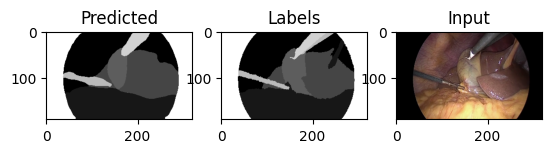

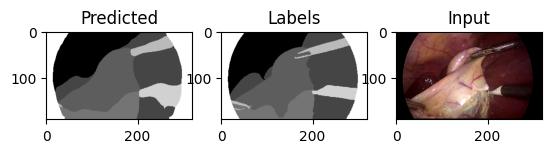

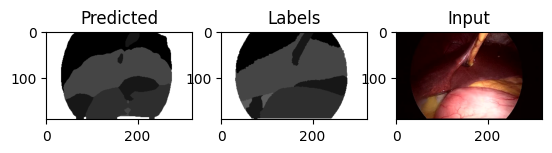

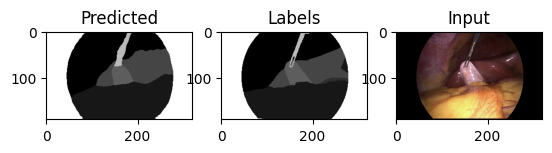

Test loss: 0.218121


0.2181210048773455

In [ ]:
test_eval(test_dataloader, fcn_transfer, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_transfer, data_dir + f"saved_models/models/fcn_transfer_{cur_time}.pt")

# EXPERIMENT 3: RECOLORIZATION

Model pretrained on the unsupervized recolorization task can be found at 'path_to_main_directory/saved_models/models/fcn_image_recolorization.pt' 


## FCN

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.090958             0.042638             0                    0.042638        749.588016     
2          0.024062             0.026978             0                    0.026978        929.919648     
4          0.017030             0.019545             0                    0.019545        1112.332226    
6          0.013839             0.016219             0                    0.016219        1295.745309    
8          0.011618             0.013509             0                    0.013509        1479.442893    
10         0.010067             0.012067             0                    0.012067        1663.725996    
12         0.009093             0.011072             0                    0.011072        1848.900763    
14         0.008871             0.010950             0                    0.010950        2029.749053    
16         0.007906         

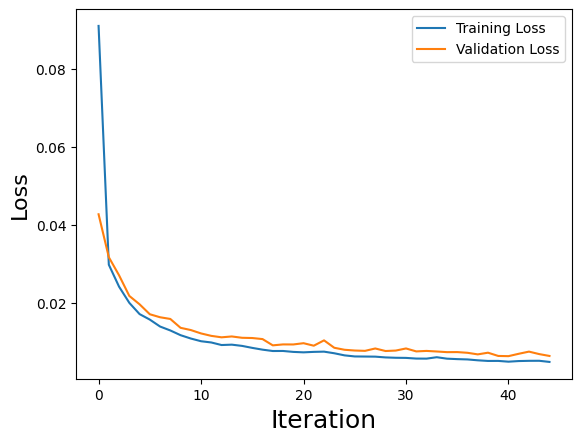

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/fcn_image_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_recolored_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_recolored_segmentation, test_dataloader, use_gpu, True)

0.8922889985012524

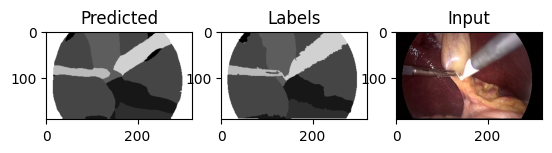

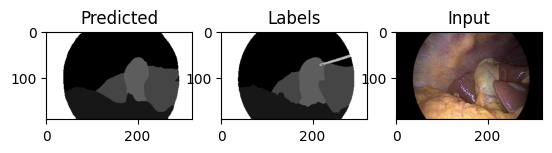

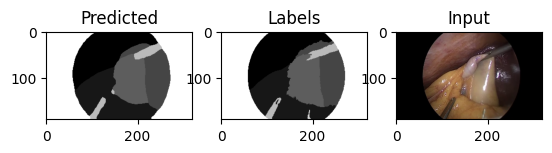

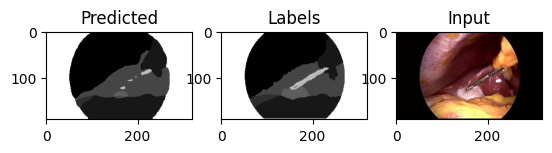

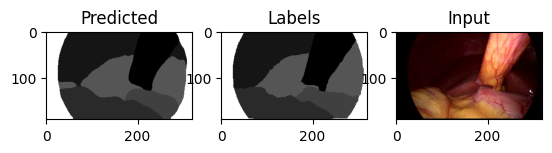

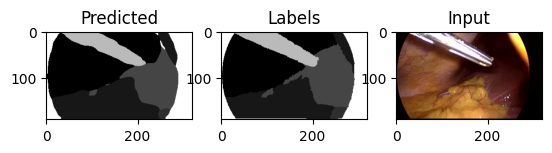

Test loss: 0.159963


0.15996282455494074

In [ ]:
test_eval(test_dataloader, fcn_recolored_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_recolored_segmentation, data_dir + f"saved_models/models/fcn_recolored_segmentation_{cur_time}.pt")

### RECOLORIZATION trained on GAN - 50% Fake Images

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

#### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.055566             0.042096             0                    0.042096        862.121339     
2          0.025562             0.027836             0                    0.027836        1037.788084    
4          0.019922             0.024047             0                    0.024047        1214.585280    
6          0.016227             0.018005             0                    0.018005        1390.537152    
8          0.014842             0.016743             0                    0.016743        1561.152786    
10         0.012663             0.015480             1                    0.015338        1732.106073    
12         0.011019             0.013494             1                    0.013358        1910.219131    
14         0.010998             0.015157             3                    0.013358        2079.302126    
16         0.009985         

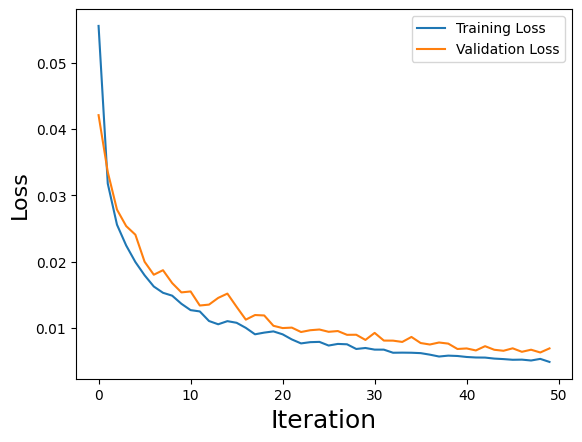

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/fcn_GAN_image_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_GAN_image_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_GAN_image_segmentation, test_dataloader, use_gpu, True)

0.8847906366553704

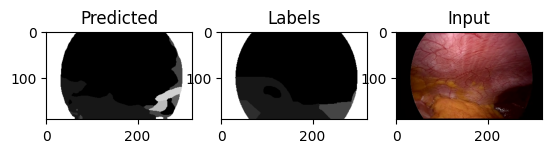

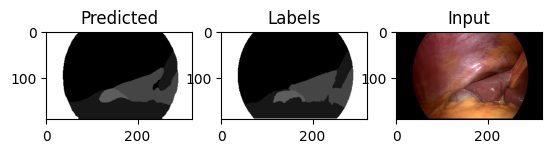

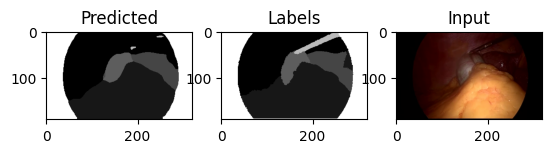

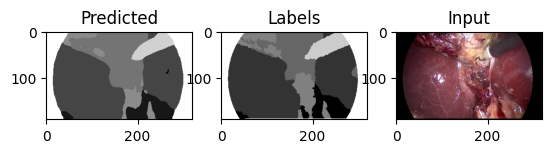

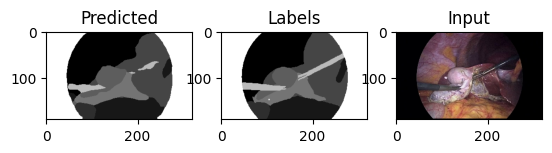

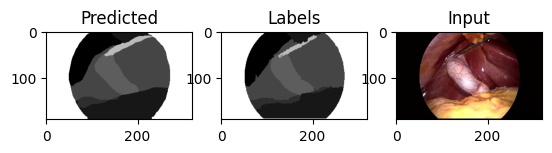

Test loss: 0.152417


0.15241709914750629

In [ ]:
test_eval(test_dataloader, fcn_GAN_image_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_GAN_image_segmentation, data_dir + f"saved_models/models/fcn_GAN_image_segmentation_{cur_time}.pt")

### RECOLORIZATION trained on GAN - 100% Fake Images

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

#### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          1.768831             0.175124             0                    0.175124        586.330440     
2          0.046824             0.050313             0                    0.050313        762.638663     
4          0.037322             0.042588             0                    0.042588        961.665656     
6          0.034067             0.038946             0                    0.038946        1172.559879    
8          0.033428             0.038487             1                    0.038036        1375.048345    
10         0.031158             0.036247             0                    0.036247        1579.561505    
12         0.030627             0.034731             0                    0.034731        1783.842577    
14         0.029577             0.033864             0                    0.033864        1985.508242    
16         0.029010         

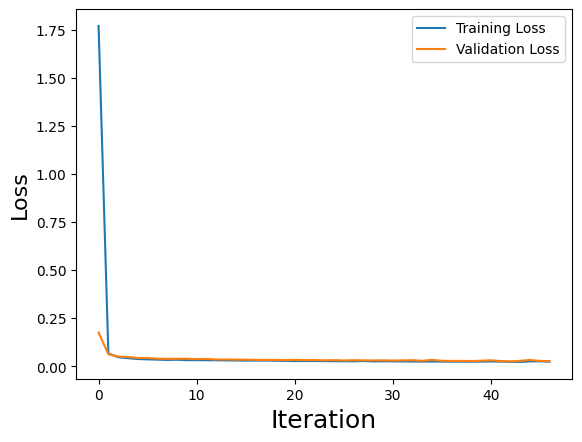

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torch.load(data_dir + 'saved_models/models/fcn_GAN_recolorization.pt')

# freezing all but last layers
for param in model.parameters():
     param.requires_grad = False

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_GAN_segmentation = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_GAN_segmentation, test_dataloader, use_gpu, True)

0.6669050080811033

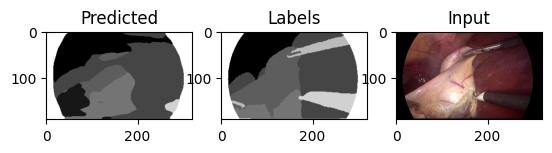

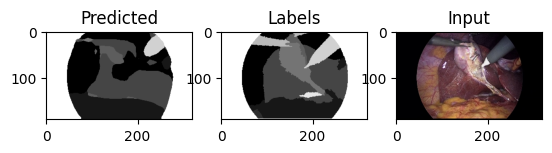

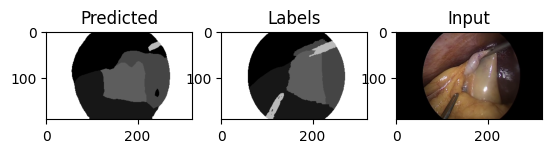

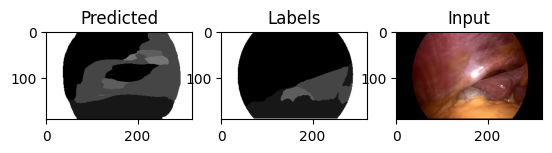

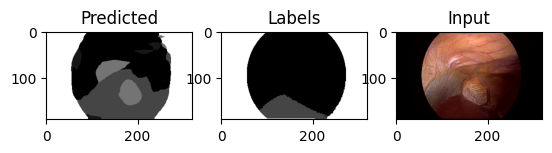

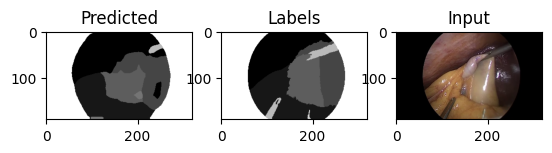

Test loss: 0.653750


0.6537503252026879

In [ ]:
test_eval(test_dataloader, fcn_GAN_segmentation, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_GAN_segmentation, data_dir + f"saved_models/models/fcn_GAN_segmentation_{cur_time}.pt")

# EXPERIMENT 4: DATA AUGMENTATION

Here, we apply RandomHorizontalFlip() and RandomVerticalFlip() to generate valid data augmentations


## Apply Data Augmentation

In [ ]:
# Redefine ImageDataset
class ImageDatasetDataAug(Dataset):
  def __init__(self, data, mask_json, req_transforms=None, data_aug=[]):
    self.data = data
    self.mask_json = mask_json
    self.transforms = req_transforms
    self.data_aug = data_aug


    with open(self.mask_json, "r") as json_file:
      self.mask = json.load(json_file)
    self.mask_num = len(self.mask)
    self.mask_values = [value for value in self.mask.values()]
    self.mask_values.sort()
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img_name, mask_name = self.data[idx]
    img = io.imread(img_name)
    mask = io.imread(mask_name)
    h, w, _ = mask.shape

    new_mask = np.zeros((h, w, self.mask_num))
    for i in range(self.mask_num):
      new_mask[:, :, i] = mask[:, :, 0] == self.mask_values[i]
    if self.transforms:
      img, new_mask = self.img_transform(img, new_mask)
    return img, new_mask

  def img_transform(self, img, mask):
    img = self.transforms(img)
    mask = self.transforms(mask)

    for i in range(len(self.data_aug)):
      if random.random() > 0.5:
        data_aug = self.data_aug[i]
        img = data_aug(img)
        mask = data_aug(mask)


    return img, mask

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1


data_aug = [transforms.functional.vflip, transforms.functional.hflip]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


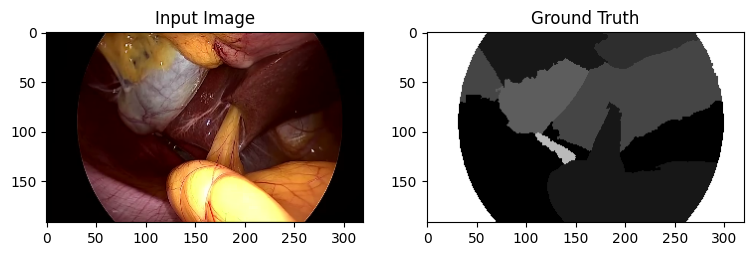

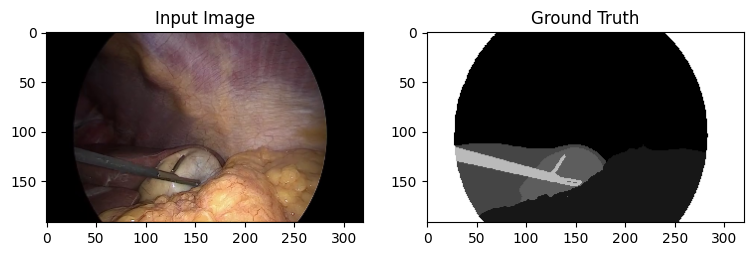

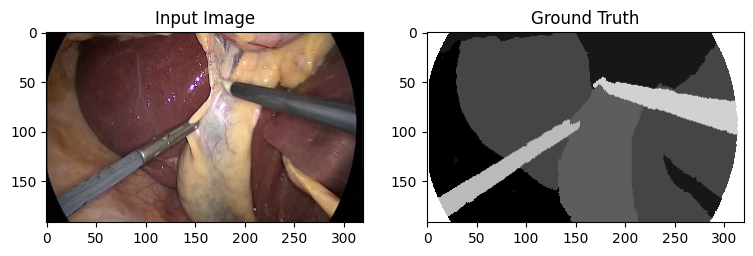

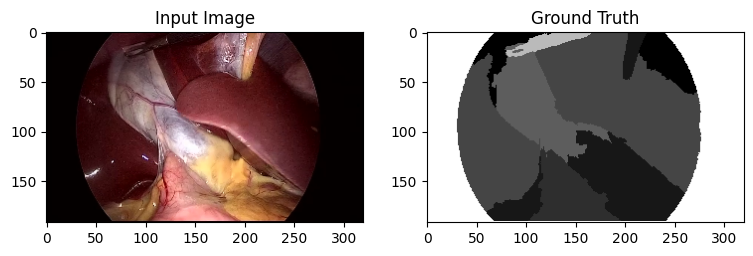

In [ ]:
visualize(train_dataloader, n_samples=4)

## FCN

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 278MB/s]


Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.078964             0.038343             0                    0.038343        676.561524     
2          0.018959             0.017241             0                    0.017241        889.560568     
4          0.011368             0.012464             0                    0.012464        1103.840020    
6          0.007459             0.008234             0                    0.008234        1315.038895    
8          0.005869             0.006590             0                    0.006590        1520.995233    
10         0.004932             0.005418             0                    0.005418        1733.416043    
12         0.004975             0.006022             1                    0.005251        1942.142142    
14         0.004093             0.004702             0                    0.004702        2152.690655    
16         0.003950         

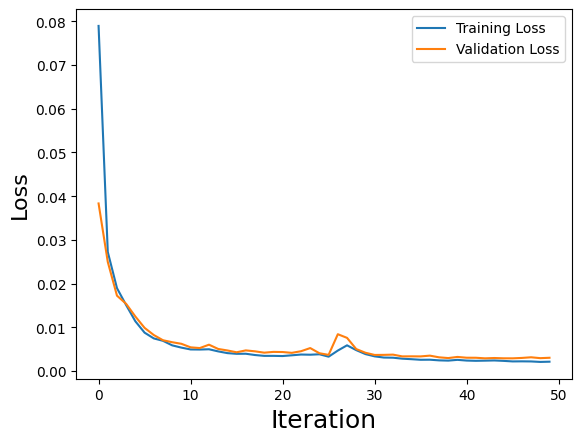

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.fcn_resnet50()

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_trained_aug = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_trained_aug, test_dataloader, use_gpu, True)

0.9540525694117502

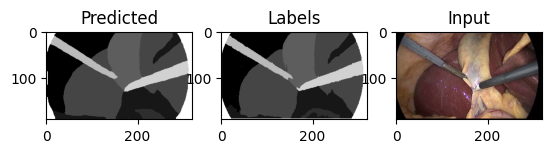

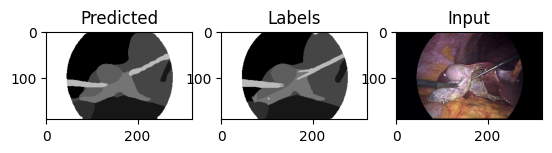

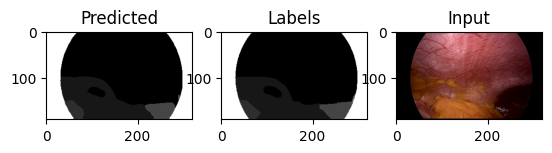

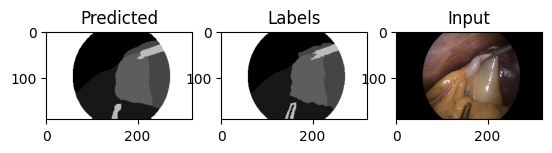

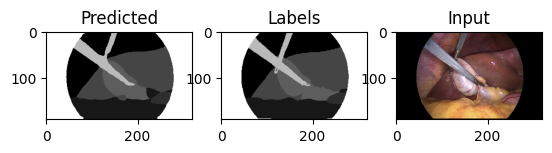

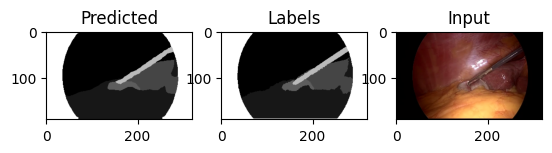

Test loss: 0.074131


0.07413096671786454

In [ ]:
test_eval(test_dataloader, fcn_trained_aug, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_trained_aug, data_dir + f"saved_models/models/fcn_trained_aug_{cur_time}.pt")

# EXPERIMENT 5: Adversarial Augmentation

Here, we add random noise to the data to mimic an Adversarial Attack in order to make the model more robust

## Apply Data Augmentation

In [ ]:
def noise(img):
  mean = 0.0
  std = 0.1
  noise = torch.normal(mean, std, size=img.shape[-2:])
  new_img = img + noise.unsqueeze(0)
  return new_img

In [ ]:
train_batch_size = 30 #32
validation_batch_size = 30 #32
test_batch_size = 1


data_aug = [noise]

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(192, 320), antialias=None),
])

######


train_dataset = ImageDatasetDataAug(data=train_datapoints, mask_json=mask_json, req_transforms=img_transforms, data_aug=data_aug)
val_dataset = ImageDatasetDataAug(data=val_datapoints, mask_json=mask_json, req_transforms=img_transforms)
test_dataset = ImageDatasetDataAug(data=test_datapoints, mask_json=mask_json, req_transforms=img_transforms)

# Train/Val Subsets
train_mask = random.sample(range(train_dataset.__len__()), num_train)
val_mask = random.sample(range(val_dataset.__len__()), num_val)
test_mask = random.sample(range(test_dataset.__len__()), num_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(train_mask))
validation_dataloader = DataLoader(dataset=val_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(val_mask))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, sampler=SubsetRandomSampler(test_mask))

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

20
4
100


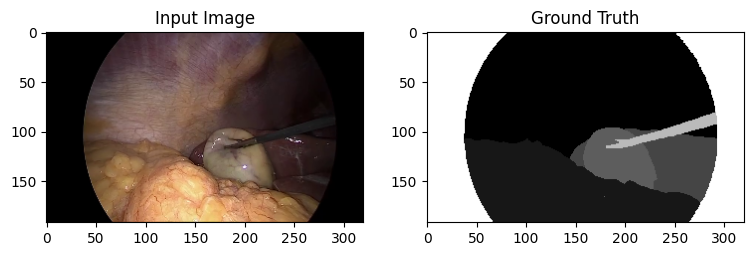

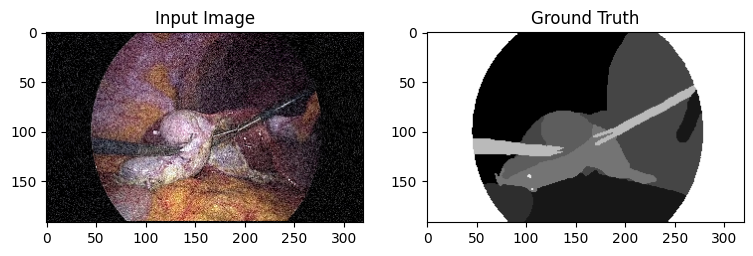

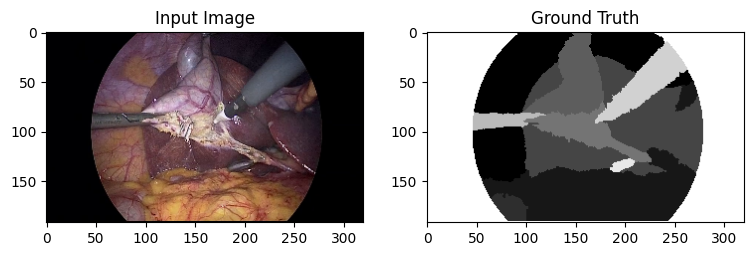

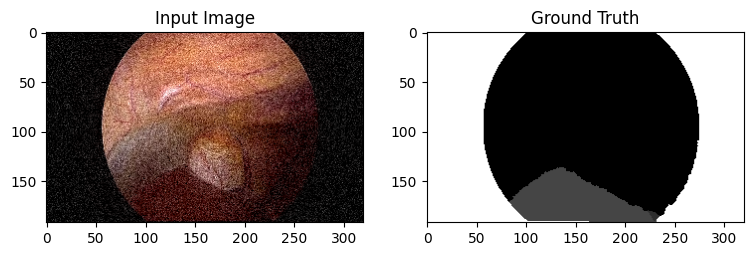

In [ ]:
visualize(train_dataloader, n_samples=4)

## FCN

In [ ]:
### Restart Runtime
torch.cuda.empty_cache()

### Training

Start Training...
epoch      train loss           val loss             es_counter(/5)       min_val_loss    time(s)        
0          0.073637             0.048146             0                    0.048146        608.093183     
2          0.025145             0.025325             0                    0.025325        822.408605     
4          0.013092             0.014218             0                    0.014218        1043.481460    
6          0.007503             0.009333             0                    0.009333        1267.413293    
8          0.005457             0.006165             0                    0.006165        1490.984628    
10         0.004326             0.005279             0                    0.005279        1713.235129    
12         0.004113             0.005436             2                    0.005279        1937.036904    
14         0.003407             0.004533             0                    0.004533        2163.303701    
16         0.002985         

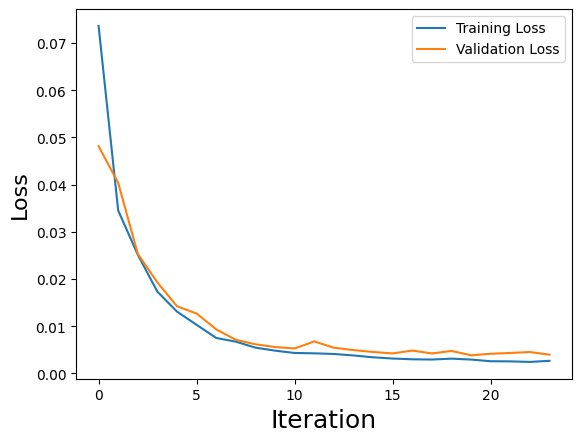

In [ ]:
from torchvision import models
import torchvision

## Run Training Loop
## Hyperparameters

## Learning Rate
learning_rate = 1e-3

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50

## Setting up the model, optimizer, and loss function
n_classes = 13
model = torchvision.models.segmentation.fcn_resnet50()

# Modify the final layer to output the correct number of classes
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, n_classes, kernel_size=1, stride=1)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.nn.CrossEntropyLoss()
fcn_trained_noise = train(model, train_dataloader, validation_dataloader, optimizer, loss, num_epochs, True)

In [ ]:
dice_score_dataset(fcn_trained_noise, test_dataloader, use_gpu, True)

0.9440193716438445

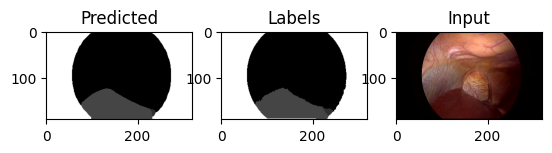

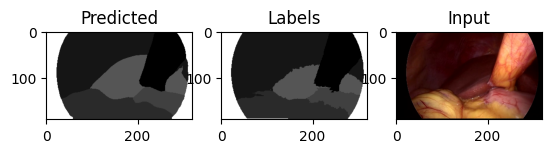

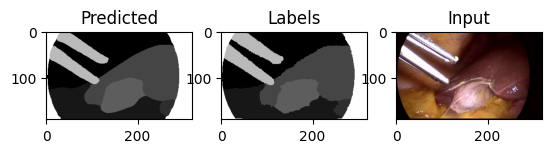

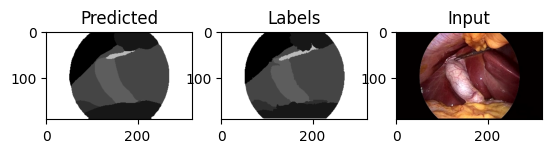

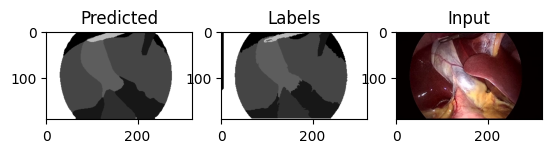

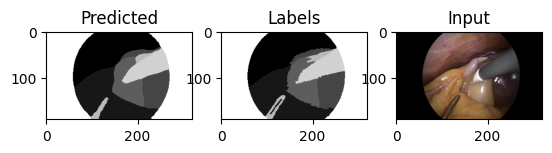

Test loss: 0.099493


0.09949263982453818

In [ ]:
test_eval(test_dataloader, fcn_trained_noise, loss, True)

In [ ]:
cur_time = datetime.now(tz).strftime('%Y_%m_%d_%H')
torch.save(fcn_trained_noise, data_dir + f"saved_models/models/fcn_trained_noise_{cur_time}.pt")